In [ ]:
!pip install praw pandas seaborn scipy

In [5]:
import csv
from datetime import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import praw
import prawcore
import random
import seaborn as sns
from typing import Callable

from utils import *

sns.set_theme()

In [54]:
import logging

# This will log everything
LOG = True
if LOG:
    handler = logging.StreamHandler()
    handler.setLevel(logging.DEBUG)
    for logger_name in ("praw", "prawcore"):
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.DEBUG)
        logger.addHandler(handler)

In [2]:
# Create the Reddit instance to do all the API stuff with
reddit = init_reddit()

In [47]:
keywords = [
    "trauma",
    "gaslight",
    "trigger",
    "toxic",
    "woke",
    "manipulat",
    "microaggression",
    "autis",
    "adhd",
    "ocd",
    "ptsd",
    "bipolar",
    "anxiety",
    "depress",
    "psycho",
    "delusion",
    "delulu",
    "solulu",
    "addict",
    "abus",
    "unstable",
    "narcissis",
    "addict",
    "neurodivergen",
]

In [5]:
random.seed(0)

first_id = int("1000000", 36)  # todo find the ID of the first post we want to analyze
last_id = int("k000000", 36)  # todo find the ID of the last post we want to analyze

In [6]:
# Run to restore state
with open("rand-state.txt", "r") as file:
    random.setstate(eval(file.readline())) # todo deserialize properly

## Query Comments

In [32]:
with open("sample-all.csv", "a") as file, open("misses.txt", "a") as misses:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
    while True:
        # IDs must be in lowercase base 36
        ids = [
            "t1_" + np.base_repr(random.randrange(first_id, last_id), 36).lower()
            for _ in range(100)
        ]
        # Ask for info on 100 IDs at once because PRAW makes batches of 100
        info = reddit.info(fullnames=ids)
        try:
            hits = []
            for submission in info:
                assert submission.name.startswith("t1"), submission.name
                hits.append(submission.name)
                # Only keep undeleted comments
                if submission.body != "[removed]" and submission.body != "[deleted]":
                    writer.writerow(comment_relevant_fields(submission))
            misses.writelines(
                id.removeprefix("t1_") + "\n" for id in ids if id not in hits
            )
        except Exception as e:
            print(e, e.__class__, id)
            break

KeyboardInterrupt: 

In [33]:
# Run to save state to pick back up later
with open("rand-state.txt", "w") as file:
    file.write(str(random.getstate())) # todo serialize properly

## Load comments

In [7]:
from datetime import datetime

df = pd.read_csv("sample-all.csv", names=COMMENT_COLS)
df.drop_duplicates(inplace=True)
df["body"] = df["body"].map(str)
df["id"] = df["name"].map(lambda name: int(name, 36))
df["time"] = df["time"].map(lambda ts: datetime.fromtimestamp(ts))

# Sort dataframe by ID/time for convenience
df.sort_values(by="id", inplace=True)
df.reset_index(inplace=True)

df

,index,name,subreddit,time,body,id
0,11599,c02dmtj,reddit.com,2007-11-04 21:14:36,"Probably the rock ad. Yeah, definitely the ro...",26125383367
1,25762,c02jlv0,reddit.com,2007-11-27 16:28:48,I wish people ordering at Tim's would take the...,26125662060
2,91535,c02m7ii,reddit.com,2007-12-07 11:14:13,"London doesn't do it with every street, and th...",26125783434
3,18821,c02mu8k,reddit.com,2007-12-10 02:45:21,How postmodern of you.,26125812884
4,51370,c02rclp,politics,2007-12-27 16:27:49,It's a government run insurance program... tha...,26126023309
...,...,...,...,...,...,...
104000,19521,jzzi5kx,TroChuyenLinhTinh,2023-09-10 12:47:07,Đẹp hẳn ra Góc cạnh đầy đủ,43534814145
104001,92568,jzzmcoj,Warthunder,2023-09-10 13:13:06,Before I got really good at making money in wi...,43535009971
104002,81401,jzzmqgd,StarWars,2023-09-10 13:15:26,all lightsabers should have an internal trigge...,43535027821
104003,65133,jzzrh9p,DavidBowie,2023-09-10 13:43:05,I’ve always loved 1. Outside. I wish he could ...,43535249197


In [8]:
# The first ID we actually collected
first_id_actual = df["id"].min()
first_id_actual, np.base_repr(first_id_actual, 36)

(26125383367, 'C02DMTJ')

#### Sanity checks

In [9]:
# Make sure no duplicates got through
assert len(df["name"]) == len(df["name"].drop_duplicates())

In [10]:
# Make sure the IDs are actually sequential
for i in range(len(df) - 1):
    curr = df.iloc[i]
    next = df.iloc[i + 1]
    assert curr.time <= next.time, f"Found out-of-order ID at {i}"

#### Actual analysis

In [11]:
def matches(body, keywords=keywords):
    for keyword in keywords:
        if keyword in body:
            return True
    return False

In [12]:
df["body"] = df["body"].map(lambda body: body.lower().strip())
matched_rows = df[df["body"].map(matches)]
matched_rows

,index,name,subreddit,time,body,id
18,2019,c03vbh4,usa,2008-04-30 13:07:08,what the trauma to the poor child being taken ...,26127888088
34,87349,c04q72l,AskReddit,2008-07-17 12:39:37,word up. people are addicted to feeling stron...,26129328717
59,99228,c06to96,reddit.com,2008-12-14 16:50:33,if you say that it is easier to pull a bag ove...,26132850186
242,53456,c0njvod,politics,2010-04-05 20:15:57,the crucial issue is on what side the folks be...,26160946717
467,88342,c18hj7s,IAmA,2010-12-09 19:14:41,>thanks for this reply! any time! i suppose ...,26196109192
...,...,...,...,...,...,...
103766,87105,jzfocjf,SFGiants,2023-09-06 16:57:46,i think that rings especially true because we ...,43501510779
103896,60735,jzqqpmx,AutisticPride,2023-09-08 19:06:32,for the full implementation of autistic repres...,43520096841
103932,19488,jztla0k,AmItheAsshole,2023-09-09 10:55:46,in order to ensure that services are being use...,43524882164
103981,3398,jzxu4ln,askSouthAfrica,2023-09-10 05:37:02,"honestly, i think there are many different psy...",43532013515


In [16]:
{
    keyword: len(matched_rows[matched_rows["body"].map(lambda body: keyword in body)])
    for keyword in keywords
}

{'trauma': 88,
 'gaslight': 21,
 'trigger': 169,
 'toxic': 137,
 'woke': 74,
 'manipulat': 97,
 'microaggression': 0,
 'autis': 54,
 'adhd': 42,
 'ocd': 21,
 'ptsd': 33,
 'bipolar': 12,
 'anxiety': 145,
 'depress': 204,
 'psycho': 148,
 'delusion': 61,
 'delulu': 0,
 'solulu': 0,
 'addict': 179,
 'abus': 287,
 'unstable': 25,
 'narcissis': 51,
 'neurodivergen': 3}

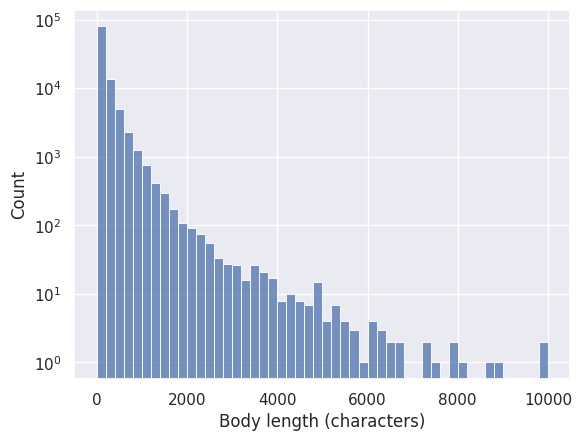

In [17]:
lengths = df["body"].map(len)
ax = sns.histplot(
    lengths[lengths <= 10000],
    binwidth=200,
    # log_scale=True
)
ax.set(xlabel = "Body length (characters)")
ax.set(yscale = "log");

In [18]:
df[lengths >= 10000]

,index,name,subreddit,time,body,id
3874,36385,ca06ttw,mindcrack,2013-05-16 17:51:52,there you go ya bot. okay: will sobriety get k...,26726368388
16124,84499,d5r64yf,Thread_crawler,2016-07-26 02:35:58,mcjfafgb/8v8qrv8n2wcshmgd1wkrjfbex2b7u0u8t8gvi...,28646137239


### Graphing distribution over time

<Axes: xlabel='time', ylabel='Count'>

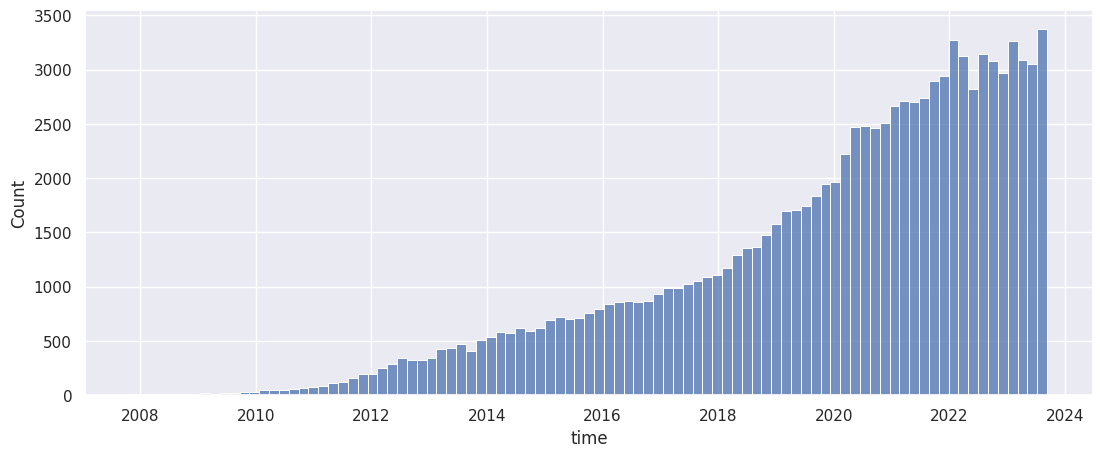

In [19]:
from datetime import timedelta

plt.figure(figsize=(13, 5))
# TODO figure out how to get binwidth to work with timedeltas
sns.histplot(data=df, x="time") #, binwidth=timedelta(days=30))

<Axes: xlabel='time', ylabel='Count'>

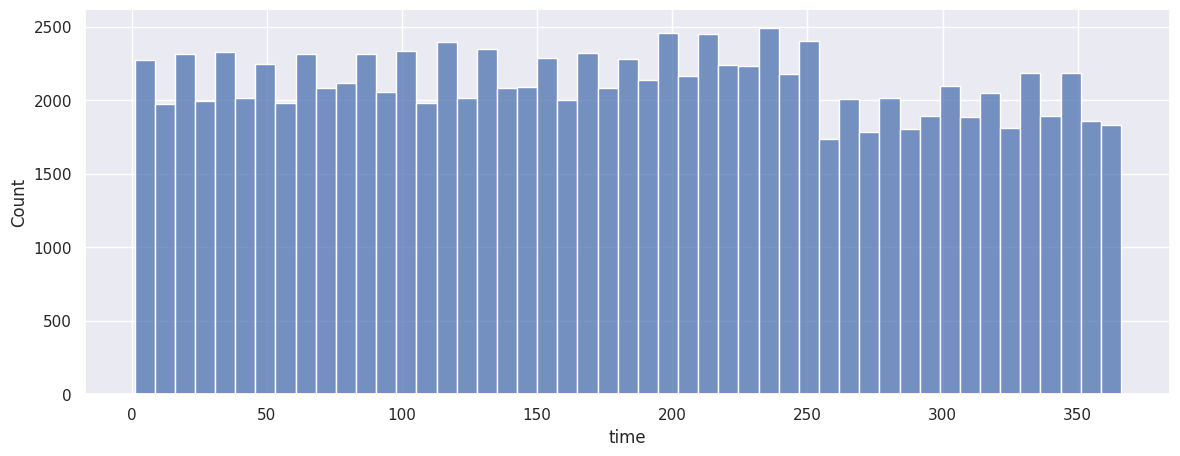

In [20]:
# Number of comments by day of year
plt.figure(figsize=(14, 5))
sns.histplot(data=df["time"].apply(lambda t: int(t.strftime("%j"))))

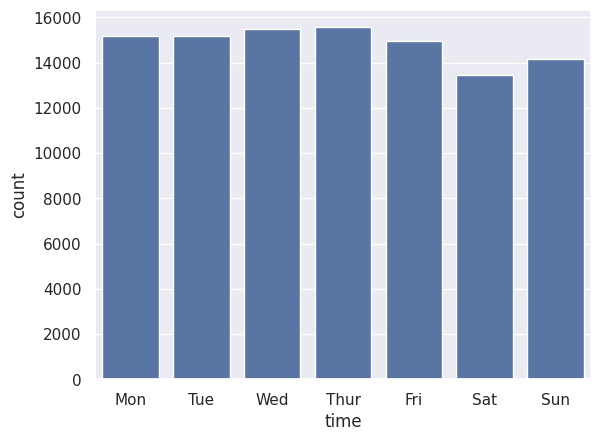

In [21]:
# Number of comments by day of week (0 = Monday)
g = sns.barplot(data=df["time"].apply(lambda t: t.weekday()).value_counts())
g.set_xticks(
    g.get_xticks(),
    labels=[
        ["Mon", "Tue", "Wed", "Thur", "Fri", "Sat", "Sun"][tick]
        for tick in g.get_xticks()
    ],
);

### Are the IDs uniformly distributed?

Figure out if the IDs are uniformly distributed using the Kolmogorov-Smirnov test

TODO check if KS is the right test to use here. Alternatives (not sure if any of these are even applicable):
- Chi-square (we don't have a normal distribution though)
- Mann-Whitney U test
- Anderson-Darling

The fact that we're taking the first gotten comment as the start rather than the actual requested
start ID might screw things up but whatever

<Axes: xlabel='id', ylabel='Count'>

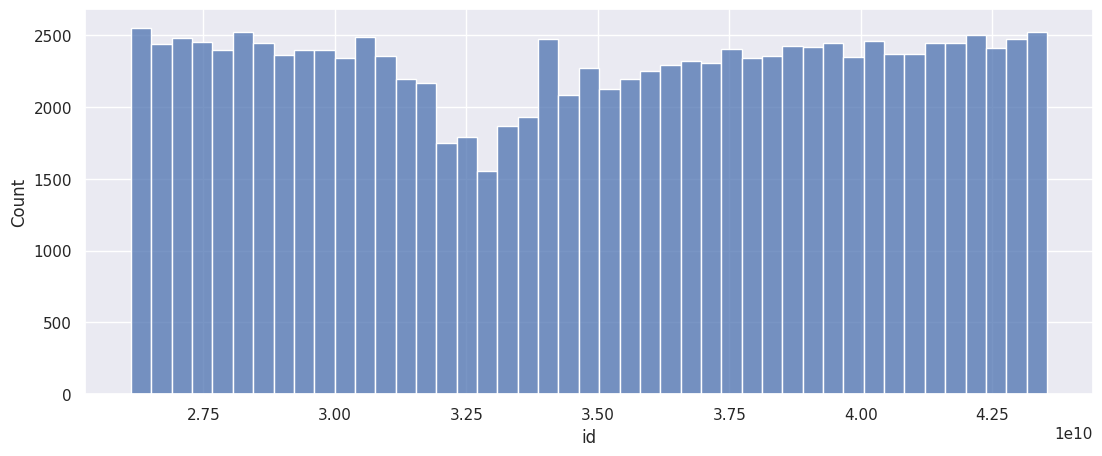

In [64]:
# Distribution of IDs

plt.figure(figsize=(13, 5))
sns.histplot(data=df["id"])

In [31]:
from scipy import stats

# Choose alpha of 0.05

ids_normalized = df["id"].map(lambda id: (id - first_id_actual) / (last_id - first_id_actual))
res = stats.ks_1samp(ids_normalized, stats.uniform.cdf)
if res.pvalue < 0.05:
    print("IDs are probably not uniformly distributed")
else:
    print("IDs are probably uniformly distributed")
res

IDs are probably not uniformly distributed


KstestResult(statistic=0.017808790224994153, pvalue=4.39617281117819e-29, statistic_location=0.5903485719662566, statistic_sign=-1)

In [32]:
# The earliest comment we have
df[df["id"] == df["id"].min()]

,index,name,subreddit,time,body,id
0,11599,c02dmtj,reddit.com,2007-11-04 21:14:36,"probably the rock ad. yeah, definitely the ro...",26125383367


In [33]:
misses = pd.Series(int(id, 36) for id in open("misses.txt", "r"))
misses

0          3983123541
1         25698587140
2         18961999379
3         12934330486
4         11977201267
             ...     
190972     8072155589
190973    20945959943
190974    14946264288
190975    18901790547
190976     2805712958
Length: 190977, dtype: int64

<Axes: >

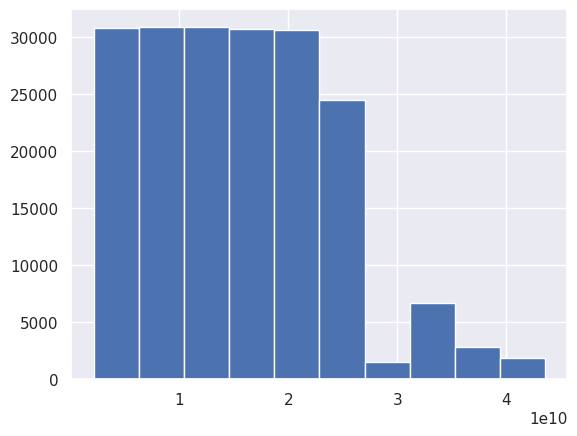

In [34]:
misses.hist()

<Axes: ylabel='Count'>

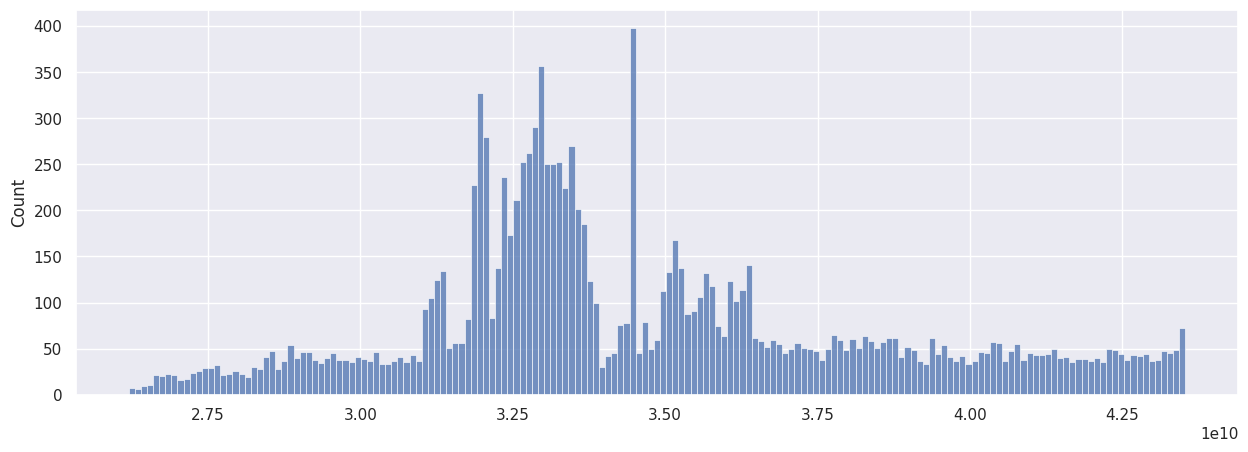

In [35]:
plt.figure(figsize=(15, 5))
misses_actual = misses[misses >= first_id_actual]
sns.histplot(misses_actual, binwidth=1e8)

<Axes: ylabel='Count'>

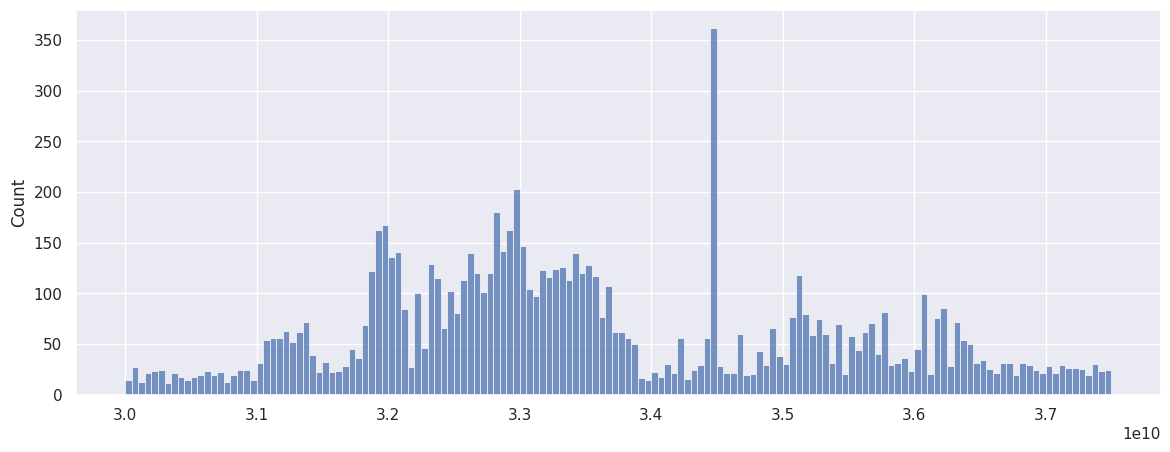

In [36]:
# Zoom in on the middle
# Note: The counts won't match the ones above because the bin width is different

# TODO How are you supposed to filter a series?
weirdos = misses[lambda id: id <= 3.75e10][lambda id: 3e10 <= id]

plt.figure(figsize=(14, 5))
sns.histplot(weirdos, binwidth=5e7)

In [37]:
# What portion of the requests we made actually returned something?
all = len(df) / (len(df) + len(misses))
# Same as above, but don't include requests for comments with IDs that were too low
exclude_invalid = len(df) / (len(df) + len(misses_actual))

all, exclude_invalid

(0.35258083544080654, 0.8900194254516204)

<Axes: xlabel='id', ylabel='rate'>

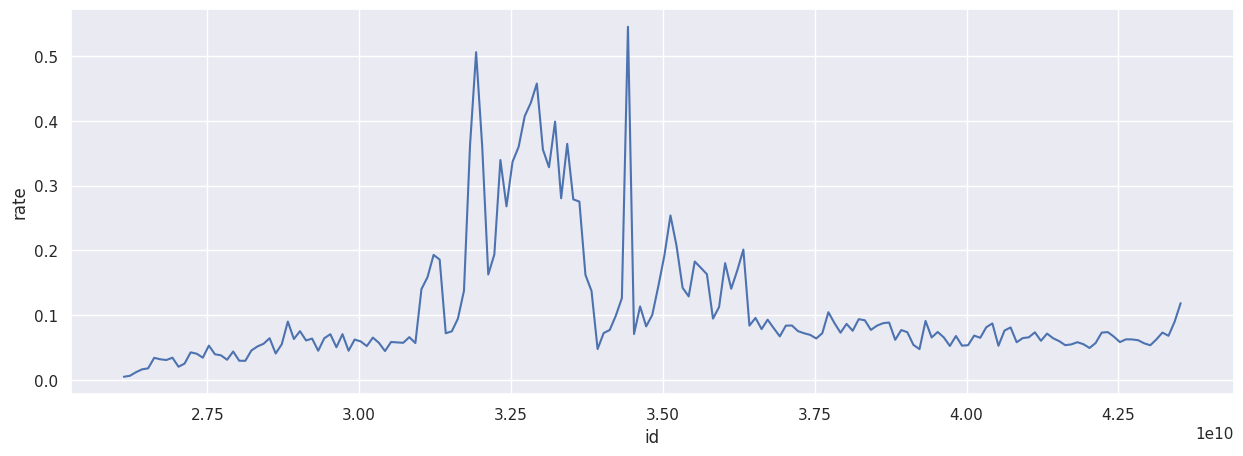

In [48]:
# Hit rate over time
start = first_id_actual
end = max(df.loc[len(df) - 1]["id"], misses.loc[len(misses) - 1])
step = int(1e8)

def get_rate(curr_id):
    next_id = curr_id + step
    hits = len(df[(curr_id <= df["id"]) & (df["id"] < next_id)])
    num_misses = len(misses[lambda id: curr_id <= id][lambda id: id < next_id])

    if num_misses == 0:
        return 0
    return num_misses / (hits + num_misses)

ids = np.arange(start, end, step)
rates = np.fromiter(map(get_rate, ids), dtype=np.dtype(np.float64))

rate_df = pd.DataFrame({ "id": ids, "rate": rates })

plt.figure(figsize=(15, 5))
sns.lineplot(data=rate_df, x="id", y="rate")

In [74]:
df[(3e10 <= df["id"]) & (df["id"] < 3.75e10)]

,index,name,subreddit,time,body,id
24492,73379,ds58nip,streetwear,2018-01-03 15:55:01,but /u/robonoodle looks much much less like a ...,30000025105
24493,76167,ds5aaqf,sex,2018-01-03 16:21:04,until death...,30000101847
24494,73308,ds5ewhf,ockytop,2018-01-03 17:37:27,"kamara consistently called out, had signature ...",30000316659
24495,43293,ds5lihp,EDC,2018-01-03 19:42:40,"that's awesome, good eye for a cool use!",30000625117
24496,52500,ds5m8wm,harrypotter,2018-01-03 19:57:16,"i like that reason though, it feels a little m...",30000659350
...,...,...,...,...,...,...
66230,80848,h868wzx,prettyaltgirls,2021-08-08 10:37:43,;),37499522829
66231,4858,h86ad6z,miraculousladybug,2021-08-08 10:49:38,stormy weather and evillustrator had cool designs,37499590475
66232,31901,h86as66,Gunners,2021-08-08 10:53:01,"saliba sees the way out now, he is happy",37499609886
66233,34074,h86c5oi,serbia,2021-08-08 11:04:13,"nedeljom je drugačiji raspored vožnje, moguće ...",37499674050


In [50]:
from scipy import stats

# Choose alpha of 0.05

misses_normalized = misses_actual.map(
    lambda id: (id - misses_actual.mean()) / (misses_actual.std())
)
res = stats.ks_1samp(misses_normalized, stats.norm.cdf)
if res.pvalue < 0.05:
    print("Misses are probably not normally distributed")
else:
    print("Misses could be normally distributed")
res

Misses are probably not normally distributed


KstestResult(statistic=0.11491448863880943, pvalue=2.641976708126364e-148, statistic_location=-0.22638444321828452, statistic_sign=1)

# `random()` Endpoint

In [59]:
all_sr = reddit.subreddit("all")
with open("random-posts.csv", "a") as file:
    writer = csv.writer(file, quoting=csv.QUOTE_MINIMAL)
    while True:
        try:
            post = all_sr.random()
            writer.writerow(post_relevant_fields(post))
        except Exception as e:
            print(e, e.__class__, id)
            break

KeyboardInterrupt: 

### Loading posts

In [60]:
df = pd.read_csv("random-posts.csv", names=POST_COLS)

df.drop_duplicates(subset=["id"], inplace=True)
df["time"] = df["time"].map(lambda ts: datetime.fromtimestamp(ts).date())
df["body"] = df["body"].fillna("")
assert not df.isna().values.any()

df

,id,time,subreddit,author,title,body,num_comments
0,1cdirkn,2024-04-26,StupidFood,zi6xd,Hot cold drink 🤦,,411
1,1cdvq9s,2024-04-26,psychedelicrock,ProjectConfident8584,Supertramp - Try Again,,0
2,1cdvqiy,2024-04-26,BrandonDE,HelicopterFar6349,Whoever supporting Dan Kuso are fucking stupid,Hate this guy,0
3,1cdvqah,2024-04-26,geometrydash,insane_demon_real,How different would the gd community be if Mic...,,0
4,1cdn255,2024-04-26,Grimdank,hydraphantom,Recent lore made Dark Eldars even more fucked up.,,154
...,...,...,...,...,...,...,...
127,1cdwhiw,2024-04-26,ShareYourSelfie,UnswornApproach78,"Sharing my selfie, can you describe it in a si...",,0
128,1cde9cz,2024-04-26,lgbt,AdamBladeTaylor,Warhammer is for everyone!,,422
129,1cdwhjv,2024-04-26,pokeplush,Even_Possession4614,Sitting Cuties from the restocks!!,,0
130,1cdulgr,2024-04-26,LiverpoolFC,Hoodxd,[Paul Joyce] Liverpool and Feyenoord have now ...,,234


In [61]:
ids = df["id"].apply(lambda id: int(id, 36))
ids.describe()

count    1.220000e+02
mean     2.925511e+09
std      2.593835e+05
min      2.924877e+09
25%      2.925278e+09
50%      2.925696e+09
75%      2.925718e+09
max      2.925727e+09
Name: id, dtype: float64

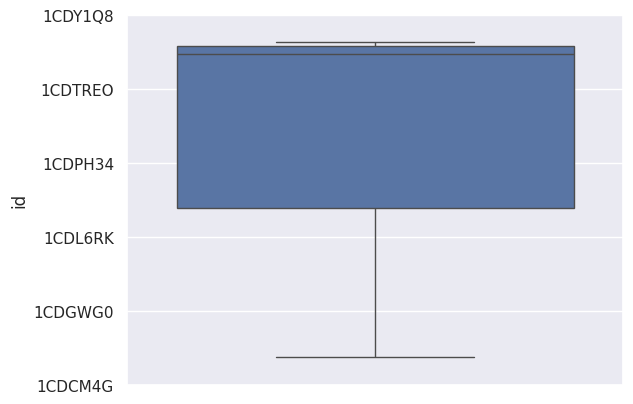

In [62]:
g = sns.boxplot(ids)
g.set_yticks(g.get_yticks(), labels=[np.base_repr(int(id), 36) for id in g.get_yticks()]);

# Distributed Sampling?

In [2]:
class Generator:
    def __init__(
        self,
        seed: int,
        end: int,
        step: int,
        iter_num: int = 0,
        id: Optional[int] = None,
    ):
        """
        # Parameters
        * `seed` - Seed to shuffle starts
        * `end` - Where the generator ends
        * `step` - Step size
        * `iter_num` - How many times we've reached `end` (0 for very start)
        * `id` - The last generated id"""

        self.end = end
        self.step = step

        rand = random.Random(seed)
        self.all_starts = list(range(step))
        rand.shuffle(self.all_starts)

        for _ in range(iter_num):
            self.all_starts.pop()

        if id is not None:
            self.id = id
        else:
            self.id = self.all_starts.pop() - step

    def get_state(self):
        iter_num = self.step - len(self.all_starts)
        return (self.seed, self.end, self.step, iter_num, self.id)

    def __next__(self):
        self.id = self.id + self.step
        if self.id <= self.end:
            return self.id

        self.id = self.all_starts.pop()
        return self.id

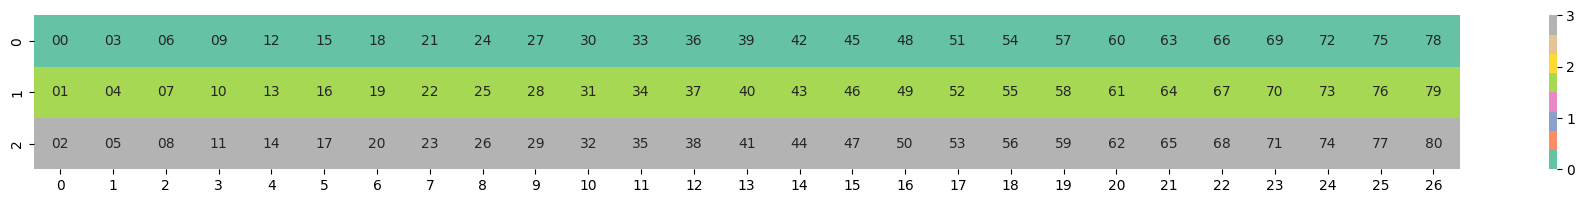

In [54]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns


num_comps = 3
end = num_comps**4  # 81 IDs in all
gens = [
    Generator(seed=i, end=end // num_comps - 1, step=num_comps * num_comps)
    for i in range(num_comps)
]

mat = [[0 for _ in range(end // num_comps)] for _ in range(num_comps)]
ids = [[j * num_comps + i for j in range(end // num_comps)] for i in range(num_comps)]

fig = plt.figure(figsize=(23, 2))

def init():
    sns.heatmap(
        mat,
        vmin=0,
        vmax=len(gens),
        cbar_kws={"ticks": list(range(len(gens) + 1))},
        cmap=sns.color_palette("Set2"),
        annot=ids,
        fmt="02d",
        # square=True,
    )


def animate(i):
    for i, gen in enumerate(gens):
        id = next(gen)
        assert mat[i][id] == 0
        mat[i][id] = i + 1
    sns.heatmap(mat, cbar=False, cmap=sns.color_palette("Set2"))


anim = animation.FuncAnimation(
    fig, animate, init_func=init, repeat=False, frames=end // num_comps,
)
anim.save("foo.mp4")
plt.show()